In [1]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm

import time
from IPython import display

import matplotlib.pyplot as plt

# VAE

In [2]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [3]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

class GaussianSampleLayer(lasagne.layers.MergeLayer):
    def __init__(self, mu, logsigma, **kwargs):
        self.rng = RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        super(GaussianSampleLayer, self).__init__([mu, logsigma], **kwargs)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.rng.normal(shape)

In [5]:
def KL_divergence(mu, log_sigma):
    KLD = 0.5 * T.sum(1 + 2*log_sigma - T.sqr(mu) - T.exp(2*log_sigma))
    return KLD

def log_likelihood(tgt, mu, ls):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + ls)
            - 0.5 * T.sqr(tgt - mu) / T.exp(2 * ls) )

In [6]:
X = np.load("./data/npy/db.npy")

In [7]:
input_X = T.matrix("X")
input_shape = [None,32*4]

In [8]:
HU_encoder = 200
HU_decoder = 200
dimZ = 3

In [9]:
vl_input = lasagne.layers.InputLayer(input_shape)
vl_enc_hid = lasagne.layers.DenseLayer(vl_input, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)
vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)
vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)
vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

In [10]:
# create prediction variable
v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
# create loss function
mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
v_loss = -1*(KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


# create parameter update expressions
v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=0.001)

# compile training and testing functions
v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
v_test_fn = theano.function([input_X], v_prediction)
v_test_loss_fn = theano.function([input_X], v_loss)
v_logloss_fn = theano.function([input_X], log_likelihood(input_X, mu_x, logsigma_x))


In [18]:
epochs = 10
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

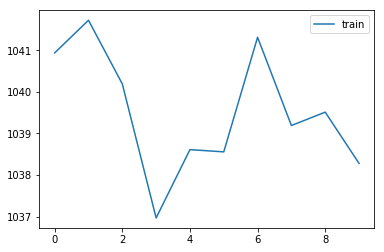

In [19]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += v_train_fn(batch)
        logloss_tr += v_logloss_fn(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    v_logloss.append(logloss_tr / batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [20]:
X_es_3 = np.load("./data/npy/ES3_R1.npy")

In [21]:
X_es_3_ans = np.load("./data/npy/ES3_R1_ans.npy.npz")

In [22]:
X_K_3 = np.concatenate(X_es_3_ans.items()[0][1][:2])
X_BL_3 = np.concatenate(X_es_3_ans.items()[0][1][2:])
X_es_3_ans = np.concatenate(X_es_3_ans.items()[0][1])

In [23]:
internal = theano.function([input_X], mu_z)

In [33]:
Z = internal(X_es_3)
Z_ans = internal(X_es_3_ans)
Z_ans_k = internal(X_K_3)
Z_ans_bl = internal(X_BL_3)

In [25]:
Z_es_3_ans.shape

(35, 3)

In [26]:
Z_ans_k.shape

(18, 3)

In [27]:
Z_ans_bl.shape

(17, 3)

In [613]:
from sklearn.manifold import TSNE

In [614]:
tsne = TSNE(2, verbose=1)

In [615]:
def tsne_with_asn(tsne, data, ans):
    print(np.concatenate((data, ans)).shape)
    tsne_data = tsne.fit_transform(np.concatenate((data, ans)))
    return tsne_data[:data.shape[0]], tsne_data[-ans.shape[0]:]

In [619]:
t, t_ans = tsne_with_asn(tsne, Z[::10], Z_es_3_ans)

(19861, 30)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19861 samples in 0.081s...
[t-SNE] Computed neighbors for 19861 samples in 2.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19861
[t-SNE] Computed conditional probabilities for sample 2000 / 19861
[t-SNE] Computed conditional probabilities for sample 3000 / 19861
[t-SNE] Computed conditional probabilities for sample 4000 / 19861
[t-SNE] Computed conditional probabilities for sample 5000 / 19861
[t-SNE] Computed conditional probabilities for sample 6000 / 19861
[t-SNE] Computed conditional probabilities for sample 7000 / 19861
[t-SNE] Computed conditional probabilities for sample 8000 / 19861
[t-SNE] Computed conditional probabilities for sample 9000 / 19861
[t-SNE] Computed conditional probabilities for sample 10000 / 19861
[t-SNE] Computed conditional probabilities for sample 11000 / 19861
[t-SNE] Computed conditional probabilities for sample 12000 / 19861
[t-SNE] Computed conditional probabili

In [620]:
t_ans.shape

(35, 2)

In [28]:
from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

In [36]:
%matplotlib notebook

<IPython.core.display.Javascript object>


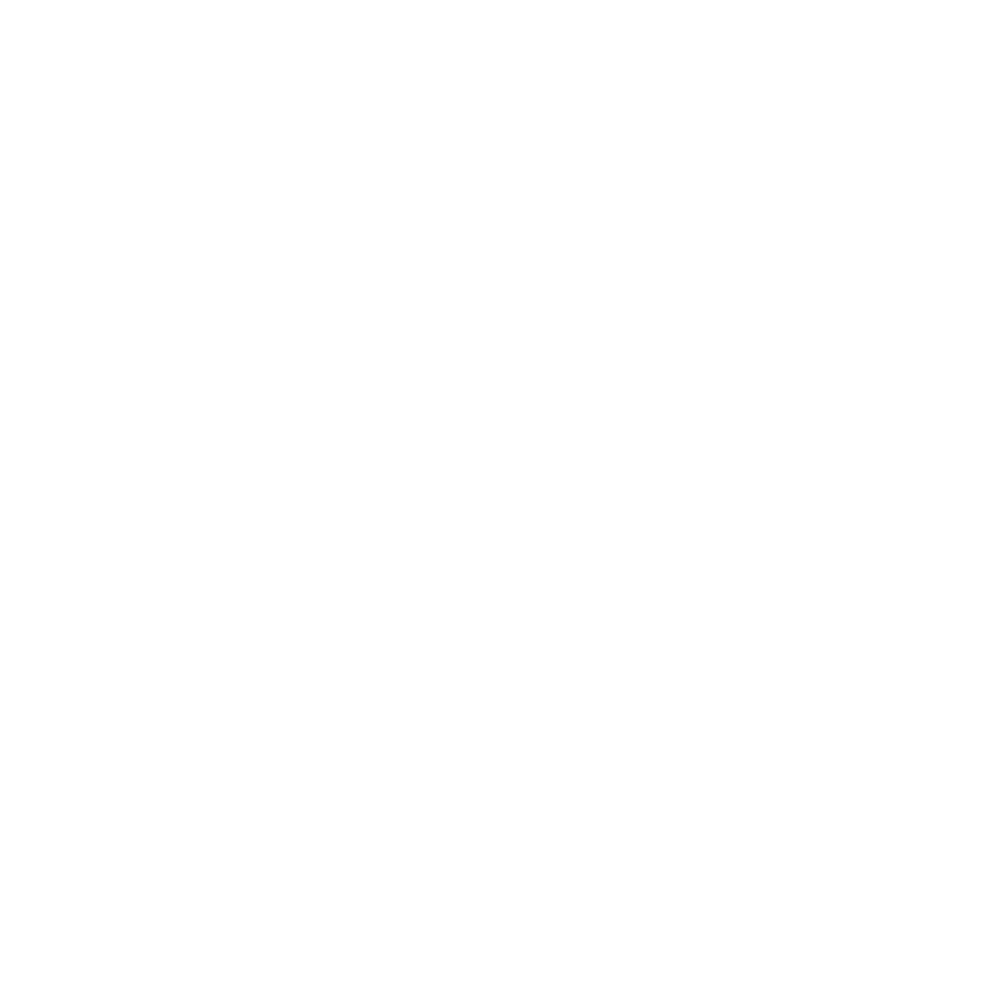

In [38]:
fig=  plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10, 10)

ax.scatter(Z_ans[:, 0][:18]  , Z_ans[:,1][:18],Z_ans[:,2,][:18], marker = 'x', s= 500, c = 'b')
ax.scatter(Z_ans[:, 0][18:]  , Z_ans[:,1][18:], Z_ans[:,2][18:],  marker = 'x', s= 500, c ='r')
ax.scatter(Z[:, 0][::10], Z[:,1][::10], Z[:,2][::10], c = 'y', alpha = 0.05)
plt.show()

In [193]:
t_u, t_ans_u = tsne_with_asn(tsne, np.unique(Z, axis = 0), Z_es_3_ans)

(2012, 30)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2012 samples in 0.002s...
[t-SNE] Computed neighbors for 2012 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2012
[t-SNE] Computed conditional probabilities for sample 2000 / 2012
[t-SNE] Computed conditional probabilities for sample 2012 / 2012
[t-SNE] Mean sigma: 0.769291
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.252552
[t-SNE] Error after 1000 iterations: 0.584939


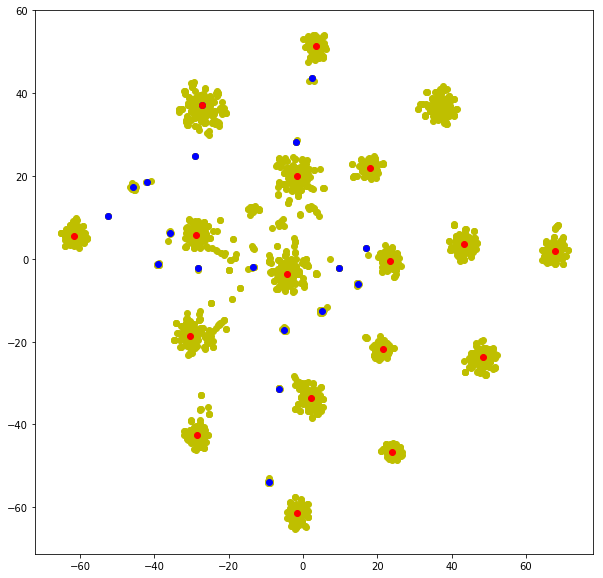

In [194]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(t_u[:, 0], t_u[:,1], c = 'y')
ax.scatter(t_ans_u[:, 0][:18]  , t_ans_u[:,1][:18], c = 'b')
ax.scatter(t_ans_u[:, 0][18:]  , t_ans_u[:,1][18:], c ='r')
plt.show()

In [39]:
from sklearn.mixture import GaussianMixture, GMM

In [40]:
clusters_num = 40

In [41]:
gmm = GaussianMixture(clusters_num, verbose = 1)

In [42]:
gmm.fit(Z)

Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=40, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [43]:
clusters_all = gmm.predict(Z)

In [44]:
clusters_ans_1 = gmm.predict(Z_es_3_ans[:18])
clusters_ans_2 = gmm.predict(Z_es_3_ans[18:])

In [45]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n))
    #colors_res = np.zeros((n, 4))
    #for i in range(n):
    #    colors_res[i] = colors(i)
    return colors

In [46]:
colors = get_cmap(clusters_num)

In [48]:
def clusters_to_colors(clusters, colors):
    cluster_colors = np.zeros((clusters.shape[0], 4))

    for i in range(clusters.shape[0]):
        cluster_colors[i] = colors[clusters[i]]
    
    return cluster_colors

In [49]:
colors_ans_1 = clusters_to_colors(clusters_ans_1, colors)
colors_all = clusters_to_colors(clusters_all, colors)
colors_ans_2 = clusters_to_colors(clusters_ans_2, colors)

In [50]:
clusters_ans_1

array([18, 25, 17, 26, 24, 26, 22, 23, 34, 27, 24, 24,  3, 20, 20, 37, 26,
       26])

In [51]:
clusters_ans_2

array([ 3,  0,  4,  6, 15,  1, 11, 16, 21, 14,  7, 10, 13,  5,  8,  9, 12])

<IPython.core.display.Javascript object>


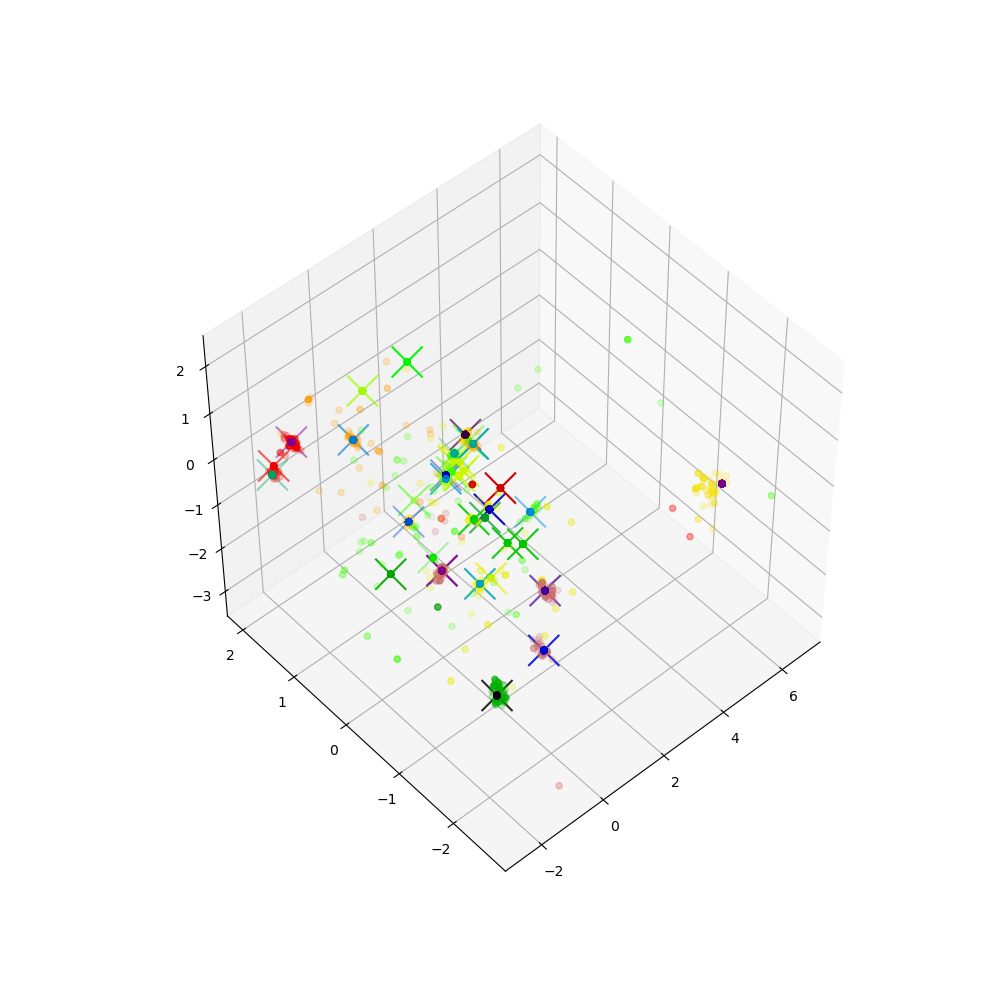

In [54]:
fig=  plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10, 10)

ax.scatter(Z_ans[:, 0][:18]  , Z_ans[:,1][:18],Z_ans[:,2,][:18], marker = 'x', s= 500, c = colors_ans_1)
ax.scatter(Z_ans[:, 0][18:]  , Z_ans[:,1][18:], Z_ans[:,2][18:],  marker = 'x', s= 500, c =colors_ans_2)
ax.scatter(Z[:, 0][::10], Z[:,1][::10], Z[:,2][::10], alpha = 0.2, c = colors_all[::10])
plt.show()

In [662]:
mask = clusters_all == 4

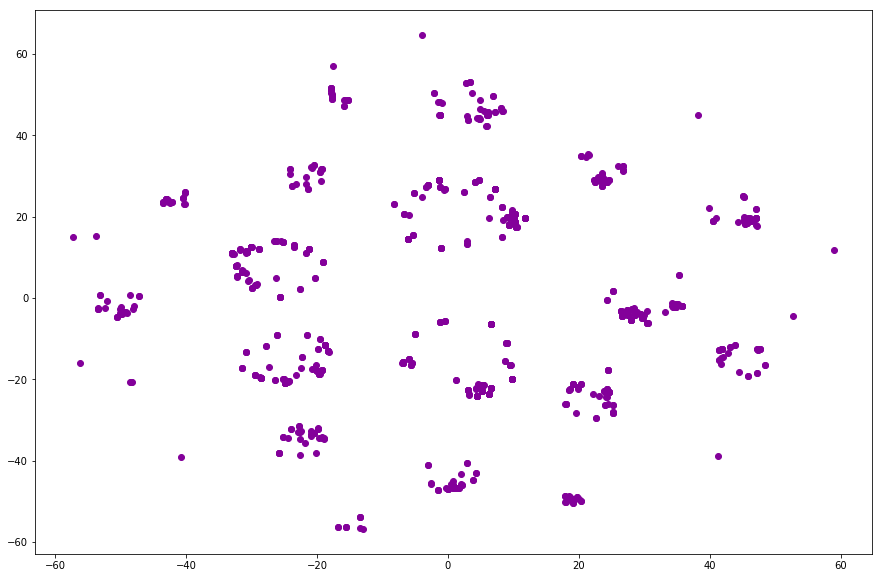

In [665]:
fig, ax =  plt.subplots()
fig.set_size_inches(15, 10)
#ax.scatter(t[:, 0], t[:,1], c=colors_all[::10])
ax.scatter(t[:, 0][mask[::10]], t[:,1][mask[::10]], c=colors[4])

#ax.scatter(t_ans[:, 0][:18]  , t_ans[:,1][:18],marker = 'x', s=500, c = colors_ans_1)
#ax.scatter(t_ans[:, 0][18:]  , t_ans[:,1][18:],marker = 'x', s=10000, c = colors_ans_2)
plt.show()

In [576]:
mask_2 = [x in set(clusters_ans_2) for x in clusters_all]

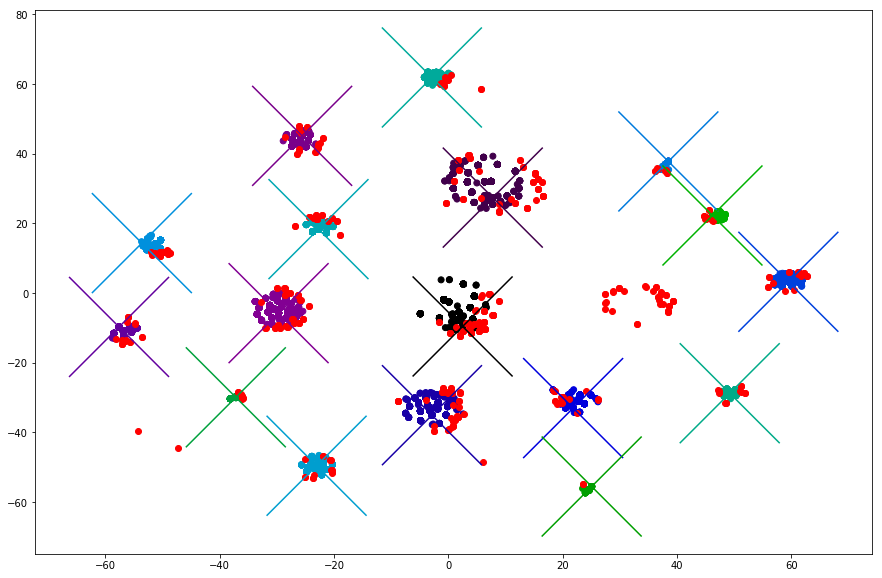

In [535]:
fig, ax =  plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(t[:, 0][mask_2], t[:,1][mask_2], c=colors_all[::20][mask_2])
ax.scatter(t[:, 0][mask_35[::20]], t[:,1][mask_35[::20]], c = 'r')
#ax.scatter(t_ans[:, 0][:18]  , t_ans[:,1][:18],marker = 'x', s=500, c = colors_ans_1)
ax.scatter(t_ans[:, 0][18:]  , t_ans[:,1][18:],marker = 'x', s=10000, c = colors_ans_2)
plt.show()

In [573]:
mask_1 = [x in set(clusters_ans_1) for x in clusters_all]

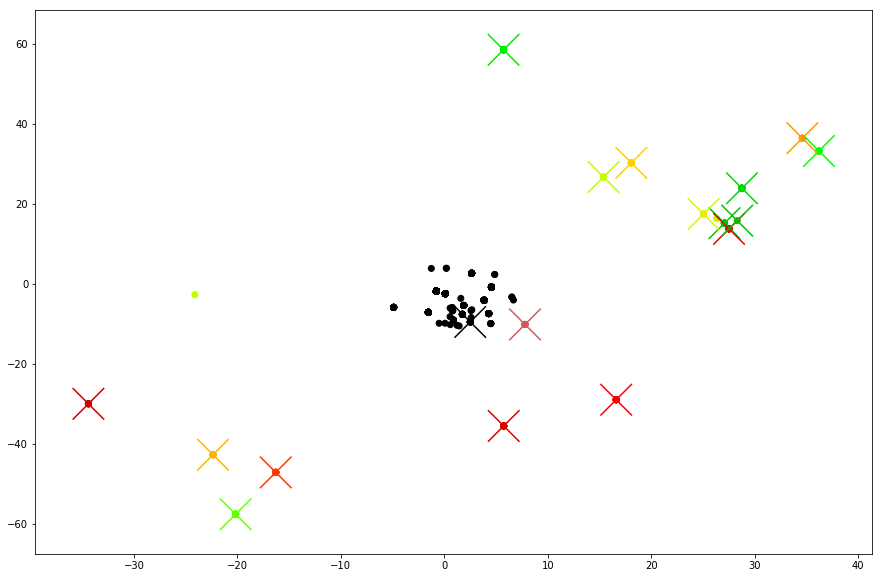

In [533]:
fig, ax =  plt.subplots()
fig.set_size_inches(15, 10)
ax.scatter(t[:, 0][mask_1], t[:,1][mask_1], c=colors_all[::20][mask_1])
#ax.scatter(t[:, 0][mask_35[::20]], t[:,1][mask_35[::20]])
ax.scatter(t_ans[:, 0][:18]  , t_ans[:,1][:18],marker = 'x', s=1000, c = colors_ans_1)
#ax.scatter(t_ans[:, 0][18:]  , t_ans[:,1][18:],marker = 'x', s=500, c = colors_ans_2)
plt.show()

In [582]:
tsne_2 = TSNE(2, verbose=1)

In [586]:
t_2 = tsne_2.fit_transform(Z[mask_1])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38178 samples in 2.646s...
[t-SNE] Computed neighbors for 38178 samples in 71.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38178
[t-SNE] Computed conditional probabilities for sample 2000 / 38178
[t-SNE] Computed conditional probabilities for sample 3000 / 38178
[t-SNE] Computed conditional probabilities for sample 4000 / 38178
[t-SNE] Computed conditional probabilities for sample 5000 / 38178
[t-SNE] Computed conditional probabilities for sample 6000 / 38178
[t-SNE] Computed conditional probabilities for sample 7000 / 38178
[t-SNE] Computed conditional probabilities for sample 8000 / 38178
[t-SNE] Computed conditional probabilities for sample 9000 / 38178
[t-SNE] Computed conditional probabilities for sample 10000 / 38178
[t-SNE] Computed conditional probabilities for sample 11000 / 38178
[t-SNE] Computed conditional probabilities for sample 12000 / 38178
[t-SNE] Computed conditional probabilities for sa

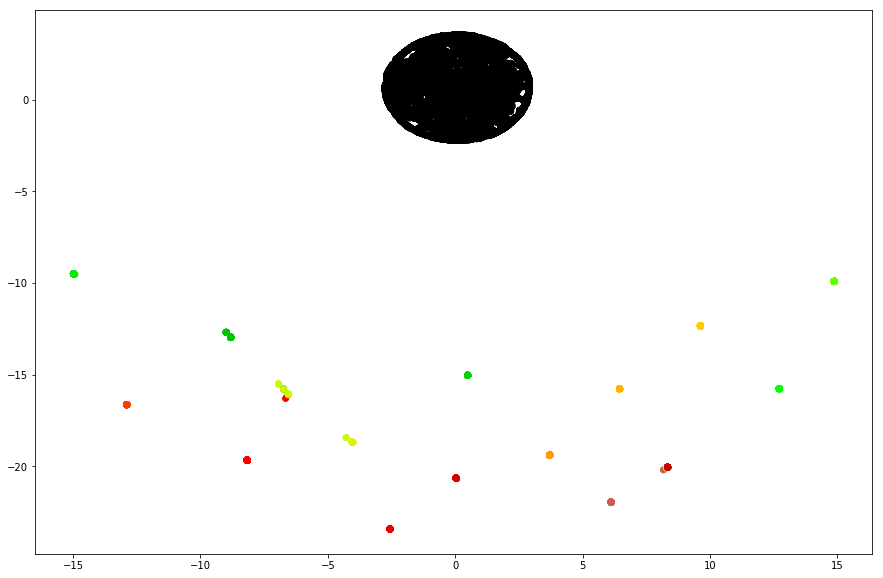

In [587]:
fig, ax =  plt.subplots()
fig.set_size_inches(15, 10)

ax.scatter(t_2[:, 0]  , t_2[:,1], c = colors_all[mask_1])#,marker = 'x', s=1000)#, c = colors_ans_1)
#ax.scatter(t_ans[:, 0][18:]  , t_ans[:,1][18:],marker = 'x', s=500, c = colors_ans_2)
plt.show()

# GRAPH

In [55]:
X_pairs = np.load("./data/npy/ES3_pairs.npy")

In [56]:
Z_pairs_0 = internal(X_pairs[:,0,:])
Z_pairs_1 = internal(X_pairs[:,1,:])

In [57]:
c_0 = gmm.predict(Z_pairs_0)
c_1 = gmm.predict(Z_pairs_1)


In [58]:
c_p = np.concatenate((c_0.reshape(-1, 1), c_1.reshape(-1, 1)), 1)

In [59]:
graph = np.zeros((clusters_num,clusters_num)).astype(int)


for p in tqdm(c_p):
    #print(i,j)
    #graph[kmeans.predict(pair[0].reshape(1,-1)), kmeans.predict(pair[1].reshape(1,-1))] += 1
    graph[p[0]][p[1]] += 1

100%|██████████| 74627/74627 [00:00<00:00, 388101.26it/s]


In [60]:
graph[:,3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [61]:
graph = graph.astype(int)

In [62]:
def to_graph(gr):
    edges = []
    curr_weight = 1000
    while curr_weight > 100:
        lin_max = np.argmax(gr)
        curr_weight = np.max(gr)
        
        print(curr_weight)
        x, y = lin_max // gr.shape[0], lin_max % gr.shape[0]
        gr[x][y] = 0
        gr[y][x] = 0

        edges.append([x, y])
    
    return edges

In [63]:
to_graph(graph)

15956
9007
8746
4800
3693
2974
2898
2809
2197
1838
1709
1354
1182
1082
972
853
716
634
602
592
486
459
437
394
371
330
327
295
281
264
227
220
214
176
176
170
142
138
132
128
126
120
119
111
110
109
108
107
105
96


[[3, 0],
 [0, 31],
 [2, 24],
 [5, 27],
 [4, 24],
 [9, 27],
 [6, 24],
 [8, 38],
 [15, 24],
 [1, 24],
 [10, 38],
 [21, 31],
 [11, 31],
 [16, 27],
 [7, 31],
 [3, 24],
 [2, 27],
 [14, 27],
 [38, 0],
 [3, 19],
 [3, 38],
 [2, 31],
 [3, 27],
 [3, 31],
 [0, 24],
 [19, 31],
 [28, 24],
 [24, 24],
 [25, 24],
 [0, 27],
 [38, 27],
 [34, 24],
 [2, 0],
 [2, 38],
 [27, 31],
 [5, 24],
 [9, 24],
 [38, 38],
 [4, 27],
 [5, 31],
 [8, 24],
 [15, 27],
 [10, 27],
 [11, 24],
 [1, 27],
 [16, 24],
 [29, 27],
 [17, 27],
 [26, 24],
 [6, 27]]

In [112]:
K_1 = ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC', 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 
       'GTAGTCCATCATTCCACCTATGTCTGAACTCC', 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 
       'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 
       'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA','TCAACATTATCAATTACAACCGACAGGGAGCC', 
       'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG']
       
K_2 = ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 'CTGTTTTCGCAAATCTATGGACTATTGCTATT', 
       'GGGCGCACGGAATACAAAGCCGTGTATCTGCT', 'TGGCTCTGCAACAGCAGCACCCATGACCACGT', 
       'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC']

In [113]:
X_ans = to_array([x[:32] for x in (K_1 + K_2)])

18it [00:00, 29433.71it/s]


### Process data

In [82]:
with open("./data/ES/ES1_R1_pairs.txt") as f:
    lines = f.readlines()
    
lines = [x[:-2] for x in lines]
pairs = [x.split(" ") for x in lines]

In [83]:
es_3 = []

for a, b in pairs:
    es_3.append(a)
    es_3.append(b)

In [84]:
es_3 = [x[:32] for x in es_3]

In [90]:
X_es_3 = to_array(es_3)

159654it [00:02, 60994.18it/s]


In [317]:
ans_es_3_1 = "CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG \
GTAGTCCATCATTCCACCTATGTCTGAACTCC CCGGGGGATAATGTTTACGGTCATGCGCCCCC TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG \
AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC TAGTTTCCGTATCTCCGGATTTATAAAGCTGA GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG \
GCGACCGCTCAGAAATTCCAGACCCGATCCAAA TCAACATTATCAATTACAACCGACAGGGAGCC AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG \
TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG "
ans_es_3_2 = "GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT \
GGGCGCACGGAATACAAAGCCGTGTATCTGCT TGGCTCTGCAACAGCAGCACCCATGACCACGT GAAATGCTGGTGAGCGTTAATGCCGCAAACAC \
ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC "
ans_es_3_3 = "GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC ACACGCCCTTATCAAATAGCTGTGATTTACCTA \
ATAGACCCCGAACAACAATACGCGCAAACCGA TACCGTACAGACTGCCGGATATTATTTTTTTG CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG \
AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC TGCATGGCTTTGGCTTCCTCTTTGACGGACGC ATATATCAGAGCAAAAAACAAAGCCACAGCCA \
CATAAAGAAACTATTTTGCGTTTCGTTCAGGT TTTTACAGTGTCAACAATCGTTCCCTGATTGT CCGCCGTTGGCACCGTCAAACTCCGGTACTGT \
TATAGAGATCGTTTTTGGAATTTACAGCGAGG CCGTAAGTGGTTTGAGCGATGATATTTGTGCT "
ans_es_3_4 = "AGTGCTGGACCATTTCAAATTCACAATAGATT GGAATGATATTTCAATAAATAATTATAACAAT \
CCCTCACACCGATTCGCCAAACGGTGGAGAAG AGCTGGGCGAAATTTTGATTCATCGTGATGAC "

In [323]:
ans_es_3 = [x[:32] for x in (ans_es_3_1 + " " + ans_es_3_2 + " " + ans_es_3_3 + " " + ans_es_3_4).split()]

In [324]:
X_ans_es_3 = to_array(ans_es_3)

35it [00:00, 27594.11it/s]


In [15]:
unique = set(K_1 + K_2)

In [9]:
kept_len = 32

In [10]:
K_1 = ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC', 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 
       'GTAGTCCATCATTCCACCTATGTCTGAACTCC', 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 
       'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 
       'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA','TCAACATTATCAATTACAACCGACAGGGAGCC', 
       'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG']
       
K_2 = ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 'CTGTTTTCGCAAATCTATGGACTATTGCTATT', 
       'GGGCGCACGGAATACAAAGCCGTGTATCTGCT', 'TGGCTCTGCAACAGCAGCACCCATGACCACGT', 
       'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC']

In [89]:
letter_to_num = {}
letter_to_num['A'] = 0
letter_to_num['C'] = 1
letter_to_num['T'] = 2
letter_to_num['G'] = 3

In [86]:
def process_spacer(spacer):
    ans = np.zeros(32*4)
    
    for i, letter in enumerate(spacer):
        if letter in letter_to_num.keys():
            ans[i*4 + letter_to_num[letter]] = 1
    return ans
    

In [13]:
def add_noize(spacer, prob = 0.99):
    noized = []
    for letter in spacer: 
        if np.random.random() > prob:
            noized.append(np.random.choice(["A","C","G","T", ""]))
        else:
            noized.append(letter)
    return ''.join(noized)

In [14]:
noised_data = []
K = K_1 + K_2
for i in tqdm(range(len(pairs) * 2)):
    noised_data.append(add_noize(np.random.choice(K), 0.97))
    

100%|██████████| 159654/159654 [00:08<00:00, 19507.01it/s]


In [17]:
counter = 0
for p in noised_data:
    if p in unique:
        counter += 1
counter

73362

In [18]:
noised_data = [x[:32] for x in noised_data]

In [87]:
def to_array(spacers):
    X = np.zeros((len(spacers), 32 * 4))

    for i, spacer in tqdm(enumerate(spacers)):
        X[i,:] = process_spacer(spacer)
    return X

In [19]:
X_noised = np.zeros((len(noised_data), 32 * 4))

for i, noised_spacer in tqdm(enumerate(noised_data)):
    X_noised[i,:] = process_spacer(noised_spacer)

159654it [00:02, 66800.41it/s]


In [20]:
X = np.zeros((len(K), 32 * 4))

for i, spacer in tqdm(enumerate([x[:32] for x in K])):
    X[i,:] = process_spacer(spacer)

18it [00:00, 24051.44it/s]


# ALL DATA

In [220]:
with open("./data/CRISPR_db_2109.txt") as f:
    db_lines = f.readlines()

In [221]:
db = [[y for y in x.split("\t")[1:-1] if len(y) > 0] for x in db_lines]

In [250]:
np.where(np.array([len(x) for x in db]) == 1)[0]

array([  21,   27,   39,   49,   56,   61,   67,   81,   86,   92,   98,
        118,  135,  161,  162,  170,  181,  237,  257,  312,  351,  365,
        404,  414,  419,  420,  424,  438,  445,  454,  458,  483,  504,
        506,  507,  509,  519,  559,  589,  604,  615,  633,  648,  661,
        674,  681,  687,  710,  755,  766,  783,  788,  789,  790,  827,
        862,  864,  897,  907,  965,  970,  976,  990, 1000, 1014, 1017,
       1025, 1049, 1052, 1074, 1075, 1093, 1154, 1161, 1192, 1208, 1213,
       1217, 1224, 1241, 1244, 1252, 1278, 1310, 1319, 1329, 1331, 1336,
       1342, 1354, 1361, 1374, 1383, 1425, 1434, 1440, 1505, 1506, 1553,
       1568, 1592, 1603, 1605, 1613, 1621, 1645, 1657, 1663, 1700, 1736,
       1737, 1751, 1755, 1795, 2024, 2300, 2345, 2463, 2502, 2503, 2504,
       2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516,
       2517, 2518, 2519, 2520, 2521, 2522, 2523, 2525, 2526, 2527, 2528,
       2529, 2530, 2531, 2532, 2533, 2534, 2535, 25

In [252]:
np.array(db_lines)[np.where(np.array([len(x) for x in db]) == 1)[0]]

array([ '@gi|675818951:288728-289015_E_coli_FHI102_scaffold-28_contig-1.2_582909_1011299\tCTGAAACCAGTTGGCTCGTTGTTCTTCTTTGG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|CP008805.1|:3680245-3680533_E_coli_O157:H7_str._SS17\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KC765388.1|:1-219_E_coli_strain_96-0611_CRISPR2a\tAAGTTCGACAACTTAAAAAATGATAACAAGTC\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522834.1|:288-576_E_coli_strain_H56909_CRISPR2\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522734.1|:1-189_E_coli_strain_TW14359_CRISPR2\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522859.1|:266-494_E_coli_strain_95.3322_CRISPR2\tATATCCGGTTTTTGCTGGTGGGCCGCGCCGT

In [260]:
all_spacers = set()

for chain in tqdm(db):
    for spacer in chain:
        all_spacers.add(spacer)

100%|██████████| 3058/3058 [00:00<00:00, 461722.22it/s]


In [261]:
all_spacers_list = [x[:32] for x in list(all_spacers) if len(x) < 40]

In [265]:
X_db = np.zeros((len(all_spacers_list), 32 * 4))

for i, spacer in tqdm(enumerate(all_spacers_list)):
    X_db[i,:] = process_spacer(spacer)

1748it [00:00, 49390.29it/s]


In [35]:
from sklearn.metrics import log_loss

In [199]:
log_loss(X[:1], v_test_fn(X[:1])) 

387.92068499768482

In [150]:
np.savez("./VAE_weights/97_noize_70_hid_10_ES1", *lasagne.layers.get_all_param_values(vl_output))

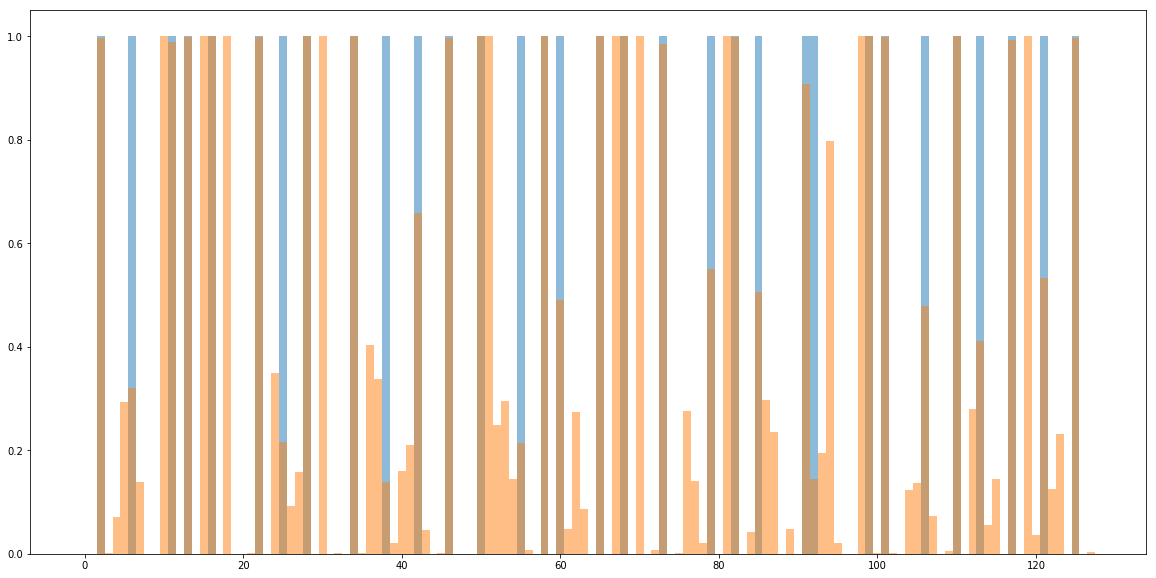

In [282]:

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.bar(np.arange(32 * 4), X_db[1:2][0][:], width = 1, alpha = 0.5)
ax.bar(np.arange(32 * 4), v_test_fn(X_db[1:2])[0][:], width = 1, alpha = 0.5)
plt.show()

## Get inside 

In [106]:
Z = internal(X_es_3)

In [325]:
Z_es_3 = internal(X_es_3)
Z_ans_es_3 = internal(X_ans_es_3)

In [286]:
Z_noized = internal(X_noised)
Z = internal(X)

на уникальных

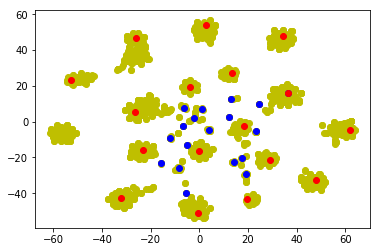

In [334]:
plt.scatter(t_noized[:, 0], t_noized[:,1], c = 'y')
plt.scatter(t_ans[:18, 0], t_ans[:18,1], c= 'b')
plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

In [346]:
mask = np.logical_and(t_noized[:, 0] > 0, t_noized[:, 1] < -20)

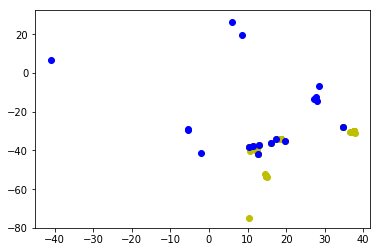

In [348]:
plt.scatter(t_noized[:, 0][mask], t_noized[:,1][mask], c = 'y')
plt.scatter(t_ans[:18, 0], t_ans[:18,1], c= 'b')
#plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

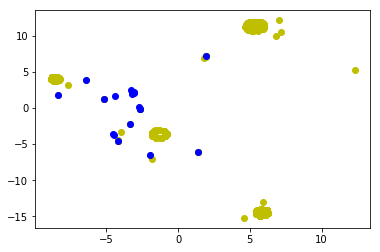

In [354]:
plt.scatter(t_noized_1[:, 0], t_noized_1[:,1], c = 'y')
plt.scatter(t_ans_1[:18, 0], t_ans_1[:18,1], c= 'b')
#plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

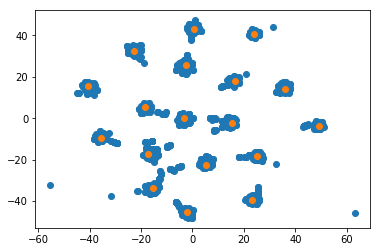

In [295]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

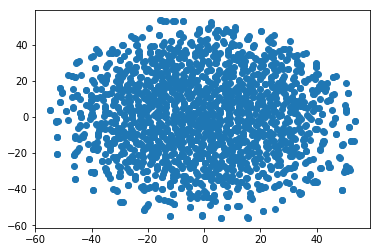

In [292]:
plt.scatter(t_db[:, 0], t_db[:,1])
#plt.scatter(Z[:, 0]  , Z[:,1])
plt.show()

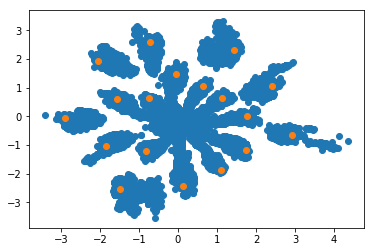

In [205]:
plt.scatter(Z_noized[:, 0], Z_noized[:,1])
plt.scatter(Z[:, 0]  , Z[:,1])
plt.show()

each 200

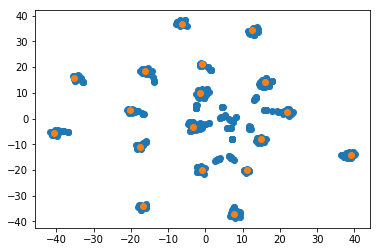

In [147]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

each 50

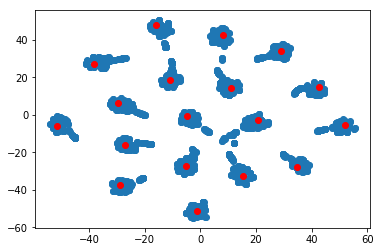

In [145]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1], c = 'R')
plt.show()

each 20

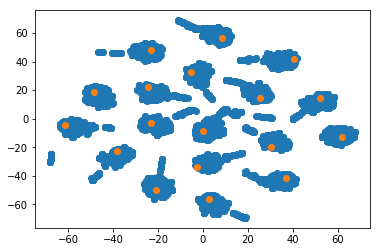

In [149]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

each 10

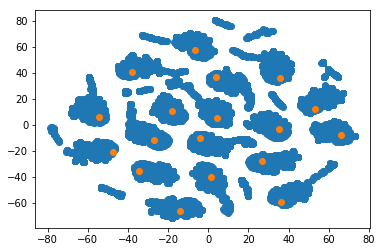

In [152]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

In [124]:
from sklearn.cluster import SpectralClustering

In [125]:
S_C = SpectralClustering(14)

In [129]:
clusters = S_C.fit_predict(Z_noized[::10])

MemoryError: 

In [108]:
from sklearn.manifold import TSNE

In [307]:
tsne = TSNE(2, verbose=1)

In [114]:
Z_noized_unique = np.unique(Z_noized, axis = 0)

In [115]:
Z_noized.shape

(159654, 10)

In [116]:
Z_noized_unique.shape

(28362, 10)

In [140]:
t_noized.shape

(3194, 2)

In [141]:
t_ans.shape

(3194, 2)

In [314]:
Z_es_3_u = np.unique(Z_es_3,  axis = 0)

In [315]:
t_es_3 = tsne.fit_transform(Z_es_3_u)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2123 samples in 0.006s...
[t-SNE] Computed neighbors for 2123 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2123
[t-SNE] Computed conditional probabilities for sample 2000 / 2123
[t-SNE] Computed conditional probabilities for sample 2123 / 2123
[t-SNE] Mean sigma: 0.480638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.015522
[t-SNE] Error after 1000 iterations: 0.430352


In [142]:
def tsne_with_asn(tsne, data, ans):
    print(np.concatenate((data, ans)).shape)
    tsne_data = tsne.fit_transform(np.concatenate((data, ans)))
    return tsne_data[:data.shape[0]], tsne_data[-ans.shape[0]:]

In [350]:
t_noized_1, t_ans_1 = tsne_with_asn(tsne, Z_es_3[::50][mask], Z_ans_es_3[:18])

(265, 20)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.000s...
[t-SNE] Computed neighbors for 265 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.672237
[t-SNE] Error after 1000 iterations: 0.359428


### Check how much unchanged

In [18]:
len(pairs)

79827

In [69]:
counter = 0
for p in np.array(pairs).flatten():
    if p in unique:
        counter += 1

In [80]:
counter = 0
for p in noised_data:
    if p in unique:
        counter += 1

In [81]:
counter

73276

In [35]:
np.array(pairs).flatten()

array(['GGGCGCACGGAATACAAAGCCGTGTATCTGCT',
       'TGGCTCTGCAACAGCAGCACCCATGACCACG',
       'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', ...,
       'CTGTTTTCGCAAATCTATGGACTATTGCTAT',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA',
       'GCAGGCGGCGACGCGCAGGGTATGCGCGATTC'],
      dtype='<U56')

In [36]:
unique

{'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
 'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG',
 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC',
 'CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
 'CTGTTTTCGCAAATCTATGGACTATTGCTATT',
 'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG',
 'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA',
 'GGGCGCACGGAATACAAAGCCGTGTATCTGCT',
 'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
 'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA',
 'TCAACATTATCAATTACAACCGACAGGGAGCC',
 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG',
 'TGGCTCTGCAACAGCAGCACCCATGACCACGT',
 'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG'}

In [38]:
ans = "CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC	TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG	GTAGTCCATCATTCCACCTATGTCTGAACTCC	CCGGGGGATAATGTTTACGGTCATGCGCCCCC	TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG	AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC	TAGTTTCCGTATCTCCGGATTTATAAAGCTGA	GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG	GCGACCGCTCAGAAATTCCAGACCCGATCCAAA	TCAACATTATCAATTACAACCGACAGGGAGCC	AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG	TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG"

In [40]:
ans.split("\t") == K_1

True

# Convolutional VAE

In [186]:
input_X = T.matrix("X")
input_shape = [None, 32*4]

In [187]:
HU_encoder = 50
dimZ = 2
HU_decoder = 50

In [188]:
vl_input = lasagne.layers.InputLayer(input_shape)

vl_reshape = lasagne.layers.ReshapeLayer(vl_input, (-1, 1, 32*4))

vl_conv = lasagne.layers.Conv1DLayer(vl_reshape, 10, 8)

In [189]:
vl_flatten = lasagne.layers.flatten(vl_conv)

In [190]:
vl_enc_hid = lasagne.layers.DenseLayer(vl_flatten, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)

vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)

vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)

In [191]:
vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)